![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

**Birte Winter**</br>
PhD Candidate, Teaching Assistant (TA)

IWH - Leibniz Institute for Economic Research

birte.winter@iwh-halle.de

# Homework: Paper trading with Deribit 

For this homework you will need a [Deribit](https://test.deribit.com/) account. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In [4]:
# Packages used in this notebook
import requests 
import pandas as pd
import time
import json
from pandas import json_normalize
from datetime import datetime, timezone, timedelta
import seaborn as sns

### Task 1: 

Use Deribit's `"/private/sell"` API endpoint to sell one **"BTC-PERPETUAL"**.

Hint: https://docs.deribit.com/?shell#trading

In [1]:
# first save your authentication

ClientID = "YOUR ID"

ClientSecret = "YOUR SECRET"

As we have to specify the amount of Bitcoins we want to buy/sell in USD, we first need to obtain the current market price of one Bitcoin in USD. To achieve this, we can use the API.

In [5]:
# function to obtain the current market price 

def get_market(instrument):
    
    # Define the URL of the endpoint
    url = "https://www.deribit.com/api/v2/public/get_book_summary_by_instrument"

    # Define the parameters
    params = {
        "instrument_name": instrument,  # Cryptocurrency to fetch data for
    }

    # Send the GET request; as public request, we don't have to authenticate
    response = requests.get(url, params=params)

    # Check if the request was successful
    if response.status_code == 200:
        data = response.json()  # Parse the response to JSON
        print('Download market data was successful')  # Print the data
    else:
        print(f"Failed to retrieve data: {response.status_code}")


    market_data = pd.DataFrame(data["result"])

    '''
    extract the current market price and round it to the closest ten; 
    this is required as the contract size of Bitcoin Perpetuals are 10 USD 
    (see https://static.deribit.com/files/USDCContractSpecsandmargins.pdf)
    '''
    market_price = int(market_data['mark_price'].values[0].round(-1)) 
    
    print(f"Current market price: {market_price}")
    
    return market_price
    


In [6]:
# call function to obtain the current market price 
get_market("BTC-PERPETUAL")

Download market data was successful
Current market price: 25960


25960

In [7]:
# define function to sell; inputs are the parameters 

def sell(params):
    
    # Define the URL of the endpoint 
    url = "https://test.deribit.com/api/v2/private/sell"

    # Send the GET request
    response = requests.get(url, params=params, auth=(ClientID, ClientSecret))
    
    if response.status_code == 200:
        data = response.json()  # Parse the response to JSON
        print(f"Trade was successful: {data['result']}")  
    else:
        print(f"Failed to trade: {response.status_code}")

    response_json = response.json()


In [8]:
# define the parameters 
params = {
    "amount": get_market("BTC-PERPETUAL"),
    "instrument_name": "BTC-PERPETUAL",
    "type": "market"
    }

# place order by calling the function 
sell(params)

Download market data was successful
Current market price: 25970
Trade was successful: {'trades': [{'trade_seq': 101332007, 'trade_id': '166679754', 'timestamp': 1686757962067, 'tick_direction': 0, 'state': 'filled', 'self_trade': False, 'risk_reducing': False, 'reduce_only': False, 'profit_loss': 0.0, 'price': 25964.0, 'post_only': False, 'order_type': 'market', 'order_id': '16492039461', 'mmp': False, 'matching_id': None, 'mark_price': 25964.67, 'liquidity': 'T', 'instrument_name': 'BTC-PERPETUAL', 'index_price': 25952.78, 'fee_currency': 'BTC', 'fee': 0.00050012, 'direction': 'sell', 'api': True, 'amount': 25970.0}], 'order': {'web': False, 'time_in_force': 'good_til_cancelled', 'risk_reducing': False, 'replaced': False, 'reduce_only': False, 'profit_loss': 0.0, 'price': 25575.5, 'post_only': False, 'order_type': 'market', 'order_state': 'filled', 'order_id': '16492039461', 'mmp': False, 'max_show': 25970.0, 'last_update_timestamp': 1686757962067, 'label': '', 'is_liquidation': False

### Task 2: 

Use Deribit's `"/private/sell"` API endpoint to sell **"BTC-PERPETUAL"** if the price drops below 50% of the current price. Furthermore, ensure that you do not trade at a price lower than 60% of the current price. If the order is not immediately executed, it should remain in the trading book until the end of the day.


Hint: https://docs.deribit.com/?shell#trading


In [9]:
# define the parameters 
params = {
    "amount": get_market("BTC-PERPETUAL"),
    "instrument_name": "BTC-PERPETUAL",
    "type": "stop_limit",
    "advanced":"usd",
    "price": int(round(get_market("BTC-PERPETUAL")*0.4,-1)),
    "trigger_price":int(round(get_market("BTC-PERPETUAL")*0.5,-1)),
    "time_in_force":"good_til_day",
    "trigger":"mark_price"
    }

Download market data was successful
Current market price: 25970
Download market data was successful
Current market price: 25970
Download market data was successful
Current market price: 25970


In [10]:
# place order by calling the function 
sell(params)

Trade was successful: {'trades': [], 'order': {'web': False, 'triggered': False, 'trigger_price': 12980.0, 'trigger': 'mark_price', 'time_in_force': 'good_til_day', 'stop_price': 12980.0, 'risk_reducing': False, 'replaced': False, 'reduce_only': False, 'profit_loss': 0.0, 'price': 10390.0, 'post_only': False, 'order_type': 'stop_limit', 'order_state': 'untriggered', 'order_id': 'SLMS-9779999', 'mmp': False, 'max_show': 25970.0, 'last_update_timestamp': 1686758012213, 'label': '', 'is_liquidation': False, 'instrument_name': 'BTC-PERPETUAL', 'direction': 'sell', 'creation_timestamp': 1686758012213, 'api': True, 'amount': 25970.0}}


### Task 3: 

Close all positions at the current market price and cancel all orders.

Hint: https://docs.deribit.com/?shell#trading


In [11]:
# Close all positions 
# Define the URL of the endpoint 
url = "https://test.deribit.com/api/v2/private/close_position"

# define the parameters 
params = {
    "instrument_name": "BTC-PERPETUAL",
    "type": "market"
    }
    
    

# Send the GET request
response = requests.get(url, params=params, auth=(ClientID, ClientSecret))

response_json = response.json()

response_json['result']

{'trades': [{'trade_seq': 101332012,
   'trade_id': '166679796',
   'timestamp': 1686758017063,
   'tick_direction': 0,
   'state': 'filled',
   'self_trade': False,
   'risk_reducing': False,
   'reduce_only': True,
   'profit_loss': -3e-07,
   'price': 25966.0,
   'post_only': False,
   'order_type': 'market',
   'order_id': '16492043101',
   'mmp': False,
   'matching_id': None,
   'mark_price': 25967.92,
   'liquidity': 'T',
   'instrument_name': 'BTC-PERPETUAL',
   'index_price': 25953.72,
   'fee_currency': 'BTC',
   'fee': 1.93e-06,
   'direction': 'buy',
   'api': True,
   'amount': 100.0},
  {'trade_seq': 101332013,
   'trade_id': '166679797',
   'timestamp': 1686758017063,
   'tick_direction': 1,
   'state': 'filled',
   'self_trade': False,
   'risk_reducing': False,
   'reduce_only': True,
   'profit_loss': -3e-08,
   'price': 25966.0,
   'post_only': False,
   'order_type': 'market',
   'order_id': '16492043101',
   'mmp': False,
   'matching_id': None,
   'mark_price': 25

In [12]:
# close all opened trades 

# Define the URL of the endpoint 
url = "https://test.deribit.com/api/v2/private/cancel_all" 

# Send the GET request
response = requests.get(url, auth=(ClientID, ClientSecret))

response_json = response.json()

response_json['result']


1

### Task 4: 

Calculate the performance of your trades. 

Here, you have multiple options to calculate the performance of your portfolio. One approach is to calculate the performance of each individual trade. However, since investors are generally more interested in the overall performance of their entire portfolio rather than individual trades, another option is to calculate the [Net Asset Value](https://en.wikipedia.org/wiki/Net_asset_value). The NAV calculation involves the following steps.


In [13]:
# Define the URL of the endpoint 
url = "https://test.deribit.com/api/v2/private/get_transaction_log"

# start date can be set individually (date as 4 days before today)
start_date = int((datetime.now(timezone.utc) - timedelta(days=4)).timestamp() * 1e3) # required type: integer
# enddate = now 
end_date = int(datetime.utcnow().timestamp()*1e3)

# define the parameters 
params = {
    "currency": "BTC",
    "start_timestamp" : start_date,
    "end_timestamp": end_date
    }
    

# Send the GET request
response = requests.get(url, params=params, auth=(ClientID, ClientSecret))

json_response = response.json()


In [14]:
data = json_response['result']

# convert results to a dataframe 
df = json_normalize(data, 'logs')

# here, we are only interested in the settlements not the trades 
df_settlement = df[df['type']=='settlement']

In [15]:
df_settlement

,username,user_seq,user_role,user_id,type,trade_id,timestamp,side,profit_as_cashflow,price_currency,...,commission,change,cashflow,balance,amount,total_interest_pl,session_upl,session_rpl,info.settlement_price,info.floating_pl
15,Birte,1686729602269585,NaN,51536,settlement,None,1686729600009,-,NaN,USD,...,NaN,-0.008258,-0.008258,99.959749,0.0,-0.000299,NaN,NaN,25911.0,0.000000
19,Birte,1686643202082526,NaN,51536,settlement,None,1686643200007,long,NaN,USD,...,NaN,0.010278,0.010278,99.968525,26840.0,-0.000377,0.010655,-0.000377,26089.0,0.010655
20,Birte,1686556802157602,NaN,51536,settlement,None,1686556800010,long,NaN,USD,...,NaN,0.002028,0.002028,99.958247,26840.0,-0.000057,0.002085,-0.000057,25822.0,0.002085
21,Birte,1686470402307534,NaN,51536,settlement,None,1686470400010,long,NaN,USD,...,NaN,0.003935,0.003935,99.956219,26840.0,-0.000097,0.004032,-0.000097,25770.0,0.004032


In [16]:
# add column with net asset vale 
df_settlement['NAV'] = df_settlement.equity * df_settlement.price

# for better understanding convert time 
df_settlement['timestamp']=pd.to_datetime(df_settlement['timestamp'],unit='ms')

C:\Users\nb\AppData\Local\Temp\ipykernel_20404\2496083618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_settlement['NAV'] = df_settlement.equity * df_settlement.price
C:\Users\nb\AppData\Local\Temp\ipykernel_20404\2496083618.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_settlement['timestamp']=pd.to_datetime(df_settlement['timestamp'],unit='ms')


In [17]:
# reset index 
df_settlement.reset_index(drop=True, inplace=True)
df_settlement

,username,user_seq,user_role,user_id,type,trade_id,timestamp,side,profit_as_cashflow,price_currency,...,change,cashflow,balance,amount,total_interest_pl,session_upl,session_rpl,info.settlement_price,info.floating_pl,NAV
0,Birte,1686729602269585,NaN,51536,settlement,None,2023-06-14 08:00:00.009,-,NaN,USD,...,-0.008258,-0.008258,99.959749,0.0,-0.000299,NaN,NaN,25911.0,0.000000,2.590064e+06
1,Birte,1686643202082526,NaN,51536,settlement,None,2023-06-13 08:00:00.007,long,NaN,USD,...,0.010278,0.010278,99.968525,26840.0,-0.000377,0.010655,-0.000377,26089.0,0.010655,2.608074e+06
2,Birte,1686556802157602,NaN,51536,settlement,None,2023-06-12 08:00:00.010,long,NaN,USD,...,0.002028,0.002028,99.958247,26840.0,-0.000057,0.002085,-0.000057,25822.0,0.002085,2.581083e+06
3,Birte,1686470402307534,NaN,51536,settlement,None,2023-06-11 08:00:00.010,long,NaN,USD,...,0.003935,0.003935,99.956219,26840.0,-0.000097,0.004032,-0.000097,25770.0,0.004032,2.575864e+06


To visualize the performance of a portfolio, there are various options available. One approach is to plot the Net Asset Value (NAV) over time, which shows the value of the portfolio at different points in time. This can provide a visual representation of the portfolio's performance.

Additionally, one can calculate the cumulative log returns of the portfolio. By comparing these returns to an index or benchmark, you can assess the portfolio's performance relative to the market.


Text(0.5, 1.0, 'NAV over Time')

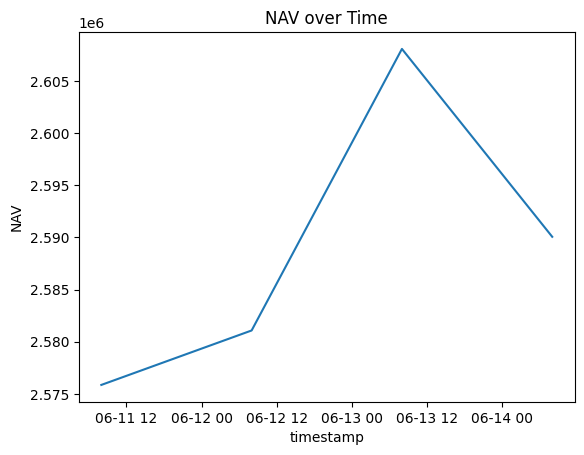

In [19]:
sns.lineplot(data=df_settlement, x="timestamp", y="NAV").set_title('NAV over Time')